### Author: Стурейко Игорь
### Project: Geekbrains.DataLibraries
### Lesson 6 - Курсовой проект - прогноз цен на квартиры
### Date: 2020-03-27

In [11]:
import warnings

warnings.filterwarnings('ignore')

import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

%matplotlib inline

# 1. Чтение данных

In [2]:
df = pd.read_csv('./train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('./test.csv')

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


11

In [3]:
# X.head()

In [4]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

In [5]:
# X.head(2)

### 1.1 Выбросы

In [6]:
X.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

**Rooms**

In [7]:
# X['Rooms'].value_counts()

# > 6 комнат, = 0 комнат

In [8]:
# X['KitchenSquare'].value_counts().sort_values()

# Площадь < 3
# Площадь > 1000

**Floor, HouseFloor**

In [9]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [10]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [11]:
(X['Floor'] > X['HouseFloor']).sum()

1825

**HouseYear**

In [21]:
X['HouseYear'].sort_values().unique()

array([1910, 1912, 1914, 1916, 1917, 1918, 1919, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1947, 1948, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [16]:
X.loc[X['HouseYear'] == 20052011, 'HouseYear'] = 2007

In [19]:
X.loc[X['HouseYear'] == 4968, 'HouseYear'] = 1968

In [22]:
X['HouseYear'].value_counts()

1977    2652
2017     308
2016     305
2015     299
2014     210
        ... 
1914       1
1947       1
1910       1
1928       1
1916       1
Name: HouseYear, Length: 95, dtype: int64

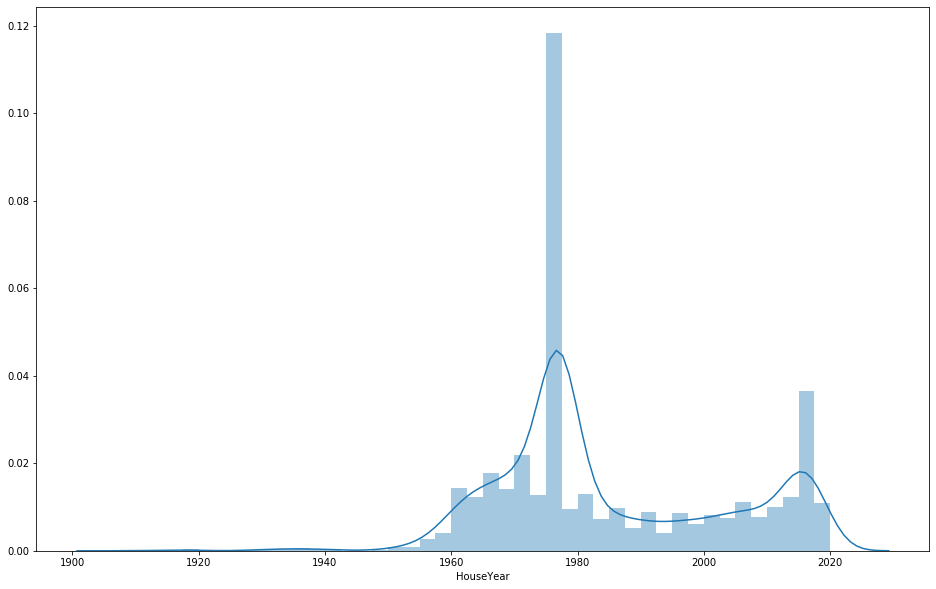

In [23]:
plt.figure(figsize=(16,10))
sns.distplot(X['HouseYear'])
plt.show()

In [13]:
X[X['HouseYear'] > 2020].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


In [14]:
(X['HouseYear'] // 1000).unique()

array([    1,     2, 20052,     4])

In [15]:
X['HouseYear'].sort_values().unique() // 100 - X['HouseYear'].sort_values().unique() // 1000*10

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 9, 0])

In [16]:
# X.loc[(X['HouseYear'] // 1000 > 2) & 
#       (X['HouseYear'] // 1000 < 10) &
#       (X['HouseYear'] // 100 - X['HouseYear'] // 1000*10 < 3),
#       'HouseYear'] = ((X.loc[(X['HouseYear'] // 1000 > 2) & 
#       (X['HouseYear'] // 1000 < 10) &
#       (X['HouseYear'] // 100 - X['HouseYear'] // 1000*10),
#       'HouseYear']) % 1000) + 1000

# X.loc[(X['HouseYear'] // 1000 > 2) & 
#       (X['HouseYear'] // 1000 < 10) &
#       (X['HouseYear'] // 100 - X['HouseYear'] // 1000*10 > 3),
#       'HouseYear'] = ((X.loc[(X['HouseYear'] // 1000 > 2) & 
#       (X['HouseYear'] // 1000 < 10) &
#       (X['HouseYear'] // 100 - X['HouseYear'] // 1000*10),
#       'HouseYear']) % 1000) + 2000

In [17]:
X.loc[(X['HouseYear'] // 1000) > 2, 'HouseYear']

Id
10814    20052011
11607        4968
Name: HouseYear, dtype: int64

In [27]:
X['Shops_1'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 15, 16, 19, 23])

In [28]:
X['Shops_1'].value_counts()

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

### Заполнение NaN

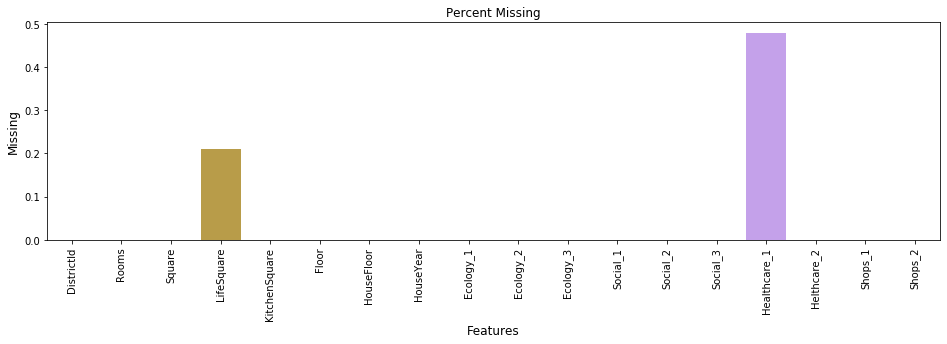

In [18]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Удалим Healthcare_1
# Заполним LifeSquare

### 1.2 Feature engineering

**DistrictId**

In [19]:
X.DistrictId.nunique()

205

In [20]:
dict(X['DistrictId'].value_counts())

{'27': 851,
 '1': 652,
 '23': 565,
 '6': 511,
 '9': 294,
 '62': 247,
 '30': 228,
 '58': 179,
 '53': 174,
 '21': 165,
 '52': 143,
 '8': 142,
 '11': 129,
 '46': 119,
 '61': 118,
 '45': 116,
 '74': 114,
 '34': 111,
 '57': 107,
 '44': 104,
 '47': 97,
 '101': 97,
 '99': 97,
 '13': 97,
 '7': 92,
 '48': 90,
 '29': 89,
 '94': 89,
 '41': 87,
 '3': 82,
 '84': 80,
 '28': 79,
 '2': 78,
 '22': 78,
 '25': 77,
 '85': 76,
 '93': 73,
 '90': 72,
 '37': 72,
 '96': 71,
 '59': 67,
 '75': 66,
 '26': 65,
 '128': 64,
 '88': 64,
 '12': 64,
 '66': 62,
 '67': 61,
 '17': 59,
 '55': 58,
 '39': 57,
 '10': 56,
 '105': 55,
 '31': 55,
 '18': 51,
 '111': 49,
 '119': 49,
 '0': 48,
 '78': 46,
 '91': 44,
 '129': 43,
 '63': 43,
 '124': 43,
 '79': 42,
 '42': 42,
 '109': 41,
 '113': 41,
 '77': 40,
 '54': 37,
 '38': 36,
 '15': 36,
 '24': 35,
 '5': 34,
 '32': 34,
 '56': 34,
 '103': 33,
 '123': 32,
 '33': 31,
 '19': 31,
 '83': 31,
 '80': 31,
 '130': 29,
 '69': 29,
 '138': 29,
 '64': 28,
 '70': 27,
 '108': 27,
 '86': 27,
 '87': 

# 2. Очистка данных

In [21]:
def zeroRooms(ds):
    """Обработка числа комнат"""
    # Когда 0 - смотрим квартиру с похожей площадью, вычисляем для них среднее количество комнат 
    # и их записываем вместо 0
    ds['Rooms_outlier'] = 0
#     ds.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
    for s in ds.loc[ds['Rooms'] < 1, 'Square'].values:
#         print('\nSquare: ' + str(s) + ':')
        nm = 0
        con = 0
        for d in ds.loc[(ds['Square'] < s*1.1) & (ds['Square'] > s*0.9), 'Rooms'].values:
            nm += d
            con += 1
#         print('Похожих квартир: ' + str(con))
#         print ('Среднее количество комнат: ' + str(np.round(nm / con, 0)))
        ds.loc[(ds['Rooms'] == 0) & (ds['Square'] == s), 'Rooms_outlier'] = 1
        ds.loc[(ds['Rooms'] == 0) & (ds['Square'] == s), 'Rooms'] = np.round(nm / con, 0)
    
    ds.loc[ds['Rooms'] == 0, 'Rooms'] = 1
    medians = ds.median()
    # в случае когда комнат больше 6 заменяем на медиану
    ds.loc[ds['Rooms'] >= 6, 'Rooms'] = medians['Rooms'] # !!! медиана посчитана на трейне !!!

In [22]:
def processingKitchenValue(ds):
#     ds.loc[(ds['KitchenSquare'] < 3) & (ds['Square'] < 40), 'KitchenSquare'] = 4
#     ds.loc[(ds['KitchenSquare'] < 3) & (ds['Square'] >= 40) & (ds['Square'] <= 60), 'KitchenSquare'] = 8
#     ds.loc[(ds['KitchenSquare'] < 3) & (ds['Square'] > 60), 'KitchenSquare'] = 12
    ds.loc[ds['KitchenSquare'] < 3, 'KitchenSquare'] = 3
    ds.loc[ds['KitchenSquare'] > 1000, 'KitchenSquare'] = ds.loc[ds['KitchenSquare'] > 1000, 'KitchenSquare'] / 10  # можно median
        

In [24]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
#         X['Rooms_outlier'] = 0
#         X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
#         X.loc[X['Rooms'] == 0, 'Rooms'] = 1
#         X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] # !!! медиана посчитана на трейне !!!
        # Обработка количества комнат.
        zeroRooms(X)
        
        # KitchenSquare
        processingKitchenValue(X)
#         X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
#         X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10  # можно median
        
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = self.medians['HouseYear']
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        return X
        

In [25]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)

# 3. Feature engineering

In [26]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец flooar_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
            
    

In [27]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)


In [28]:
# Удаляю, просто чтобы было быстрее строить модель. Возможно, вам стоит что-то сделать с не количественными признаками
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                  'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan',
                   'HouseFloor', 'HouseYear',
                   
                  'DistrictId_count', 'new_district', 'Ecology_2', 'Ecology_3', 'Shops_2',
                  'MedPriceByDistrict',
                  'MedPriceByFloorYear']

X = X[remain_features]
X_final = X_final[remain_features]

# 4. Модель

In [29]:
model = LGBMRegressor(max_depth=30,
                             min_samples_leaf=10,
                             n_estimators=300,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.736 +- 0.018


In [30]:
# Обучаю модель на всем трейне
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=30,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

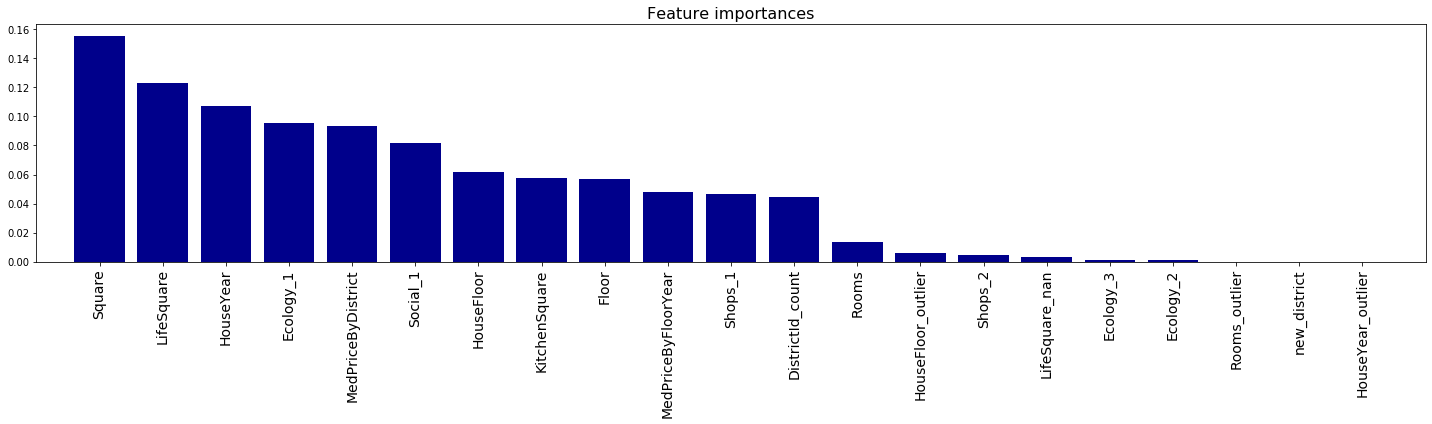

In [31]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [32]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions_7_year.csv', index=False)

preds_final.head()

,Id,Price
0,725,149101.278283
1,15856,243282.786362
2,5480,166385.936623
3,15664,326425.795832
4,14275,146466.145897


In [33]:
print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.736 +- 0.018


R2: 0.737 +- 0.019